In [1]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from os.path import join
from scipy.io import wavfile
from scipy.signal import stft
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.layers import Conv1D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.initializers import RandomUniform
from keras.layers import Activation, TimeDistributed, GRU
from keras.layers import Dense, Input, Dropout, LSTM, Concatenate, concatenate

In [2]:
BASIC_DATA_PATH = "/kaggle/input/rain-drop-count-basic/rain_drops_dataset.csv"
AUDIO_FILE_PATH = "/kaggle/input/rain-drop-mini-splitted/rain_drop_data"
basic_data = pd.read_csv(BASIC_DATA_PATH)
SAMPLE_LENGTH = 9600
VALIDATION_SPLIT = 0.25
EPOCHS = 50
BATCH_SIZE = 32
model_name = "./model/dnn.hdf5"
LEARNING_RATE = 0.001
FRAME_SIZE = 1024

In [3]:
basic_data.shape

(263, 2)

In [4]:
basic_data = basic_data.drop_duplicates(["file_name"])
basic_data["n_drops"].value_counts()

n_drops
1.0    168
0.0     45
2.0     43
3.0      3
Name: count, dtype: int64

In [5]:
df_minority_1  = basic_data[basic_data["n_drops"]==0]
df_minority_2  = basic_data[basic_data["n_drops"]==2]
df_majority = basic_data[basic_data["n_drops"]==1]
df_majority = df_majority.sample(len(df_minority_2), random_state=0)
df = pd.concat([df_majority,df_minority_1, df_minority_2])
basic_data = df.sample(frac=1, random_state=0)
basic_data = basic_data[~basic_data["n_drops"].isin([3])]

In [6]:
basic_data["n_drops"].value_counts()

n_drops
0.0    45
1.0    43
2.0    43
Name: count, dtype: int64

In [7]:
N_CLASSES = 3

In [8]:
raw_data = np.empty((0, int(SAMPLE_LENGTH)), float)
for idx, row in basic_data.iterrows():
    Fs, x = wavfile.read(join(AUDIO_FILE_PATH, row["file_name"]))
    x /= np.max(np.abs(x), axis=0)
    raw_data = np.vstack([raw_data, x])

In [9]:
def create_dnn_data(raw_data):
    spectrum_data = np.empty((0, int(SAMPLE_LENGTH)), float)
    for audio in tqdm(raw_data):
        xfft = np.abs(np.fft.fft(audio))
        spectrum_data = np.vstack([spectrum_data, xfft])
    return spectrum_data

In [10]:
dim = [513, 38]
def create_cnn_data(raw_data):
    stft_data = np.empty(shape=[0, dim[0], dim[1]])
    mfcc_data = np.empty(shape=[0, 13])
    chroma_data = np.empty(shape=[0, 12])
    mel_data = np.empty(shape=[0, 128])
    for row in raw_data:
        Zxx = librosa.stft(row, n_fft=FRAME_SIZE)
        stft_sample = np.abs(Zxx)
        stft_data = np.vstack([stft_data, stft_sample[np.newaxis,...]])
        mfccs = np.mean(librosa.feature.mfcc(y=row, sr=Fs, n_mfcc=13), axis=1)
        mfcc_data = np.vstack([mfcc_data, mfccs[np.newaxis,...]])
        chroma = np.mean(librosa.feature.chroma_stft(y=row, sr=Fs), axis=1)
        chroma_data = np.vstack([chroma_data, chroma[np.newaxis,...]])
        mel = np.mean(librosa.feature.melspectrogram(y=row, sr=Fs), axis=1)
        mel_data = np.vstack([mel_data, mel[np.newaxis,...]]) 
    return stft_data, mfcc_data, chroma_data, mel_data

In [11]:
def create_dnn_model(in_shape):
    model = Sequential()
    model.add(Dense(16, activation="relu", input_shape=in_shape))
    model.add(Dense(32, activation="relu", input_shape=in_shape))
    model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dense(N_CLASSES,
                    kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05),
                    kernel_regularizer=l2(0.001),
                    activation="softmax"))

    model.compile(optimizer=adamopt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model

In [12]:
def create_functional_model():
    input_2d = Input(shape=(513, 38), name='input_2d')
    flattened_2d = Flatten()(input_2d)
    input_1d_1 = Input(shape=(13,), name='input_1d_1')
    input_1d_2 = Input(shape=(12,), name='input_1d_2')
    input_1d_3 = Input(shape=(128,), name='input_1d_3')
    flattened_2d = Dense(128, activation='relu')(flattened_2d)
    merged_inputs = concatenate([flattened_2d, input_1d_1, input_1d_2, input_1d_3])
    x = Dense(256, activation='relu')(merged_inputs)
    x = Dense(128, activation='relu')(x)
    output = Dense(N_CLASSES, activation='softmax', name='output')(x)

    model = Model(inputs=[input_2d, input_1d_1, input_1d_2, input_1d_3], outputs=output)
    model.compile(optimizer=adamopt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model

In [13]:
def create_cnn_model(in_shape):
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(16, kernel_initializer=RandomUniform(minval=-0.05,
                    maxval=0.05), kernel_regularizer=l2(0.001),
                    activation='relu'))
    model.add(Dense(N_CLASSES, kernel_initializer=RandomUniform(minval=-0.05,
                    maxval=0.05), kernel_regularizer=l2(0.001),
                    activation='softmax'))
    
    model.compile(optimizer=adamopt,
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [14]:
def plot_history(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("log Loss")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

In [15]:
target = basic_data["n_drops"]

# spectrum_data = create_dnn_data(raw_data)
stft_data, mfcc_data, chroma_data, mel_data = create_cnn_data(raw_data)

X_train_stft, X_test_stft,\
X_train_mfcc, X_test_mfcc, \
X_train_chroma, X_test_chroma,\
X_train_mel, X_test_mel, y_train, y_test = train_test_split(
    stft_data,
    mfcc_data,
    chroma_data,
    mel_data,
    target,
    test_size=VALIDATION_SPLIT,
    random_state=2)

/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [16]:
adamopt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [17]:
# in_shape = X_train[0].shape
# model = create_dnn_model(in_shape)
# model = create_cnn_model(in_shape)

model = create_functional_model()


cp_callback = ModelCheckpoint(filepath=model_name,
                              monitor="val_loss",
                              verbose=0,
                              save_best_only=True,
                              save_weights_only=True,
                              mode="min")

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2d (InputLayer)       [(None, 513, 38)]            0         []                            
                                                                                                  
 flatten (Flatten)           (None, 19494)                0         ['input_2d[0][0]']            
                                                                                                  
 dense (Dense)               (None, 128)                  2495360   ['flatten[0][0]']             
                                                                                                  
 input_1d_1 (InputLayer)     [(None, 13)]                 0         []                            
                                                                                              

In [19]:
history = model.fit([X_train_stft, X_train_mfcc, X_train_chroma, X_train_mel],
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=([X_test_stft, X_test_mfcc, X_test_chroma, X_test_mel], y_test),
                    callbacks=[cp_callback],
                    verbose=1)

Epoch 1/50
4/4 [==============================] - 1s 131ms/step - loss: 24.4805 - accuracy: 0.4898 - val_loss: 8.3588 - val_accuracy: 0.6667
Epoch 2/50
4/4 [==============================] - 0s 46ms/step - loss: 2.9402 - accuracy: 0.6633 - val_loss: 3.3741 - val_accuracy: 0.6970
Epoch 3/50
4/4 [==============================] - 0s 41ms/step - loss: 1.8104 - accuracy: 0.7245 - val_loss: 1.9663 - val_accuracy: 0.7576
Epoch 4/50
4/4 [==============================] - 0s 34ms/step - loss: 2.0001 - accuracy: 0.7857 - val_loss: 2.8445 - val_accuracy: 0.6667
Epoch 5/50
4/4 [==============================] - 0s 36ms/step - loss: 0.8358 - accuracy: 0.8061 - val_loss: 4.4287 - val_accuracy: 0.6970
Epoch 6/50
4/4 [==============================] - 0s 33ms/step - loss: 1.2553 - accuracy: 0.7755 - val_loss: 3.3528 - val_accuracy: 0.7273
Epoch 7/50
4/4 [==============================] - 0s 36ms/step - loss: 0.8894 - accuracy: 0.8980 - val_loss: 2.2836 - val_accuracy: 0.7273
Epoch 8/50
4/4 [=========

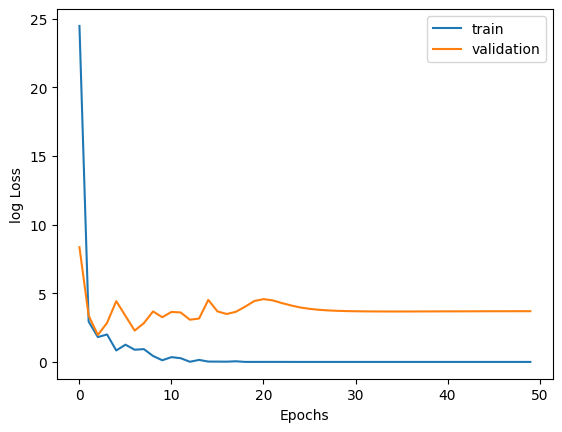

In [20]:
plot_history(history)

In [21]:
model.load_weights(model_name)
test_loss, test_accuracy = model.evaluate([X_test_stft, X_test_mfcc, X_test_chroma, X_test_mel], y_test, verbose=1)
row_df = pd.DataFrame({"EPOCHS": EPOCHS,
                       "Test_Accuracy":"{:5.2f}% ".format(100 * test_accuracy),
                       "Test_Loss":test_loss}, index=[0])

2/2 [==============================] - 0s 6ms/step - loss: 1.9663 - accuracy: 0.7576


In [22]:
model.save_weights(model_name, overwrite=True)

In [23]:
row_df

,EPOCHS,Test_Accuracy,Test_Loss
0,50,75.76%,1.966277
